## Binary Image Classification: Pizza vs. Not Pizza

Authors: Chloe Veth and Sharon Dunbar

Our goal is to build a binary image classifier. Through applying different machine learning classification techniques, we are hoping to differentiate between images of pizza and images of other food that is not pizza
#### Our dataset
We found our data on Kaggle: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza. The dataset contains 1966 images with an even split between images that are pizza and images that are not. Each image is 512 pixels on the longest side. 

To download the dataset for yourself, please visit our GitHub repository: https://github.com/chloeveth/ML-Project.


#### Libraries that we are using

In [2]:
# for image manipulation (not downloaded on lab machines)
import cv2

# for displaying graphs and image
import matplotlib.pyplot as plt

# for machine learning
import sklearn

# general purpose 
import os
import numpy as np

#### Transforming data
These steps will take the training data, transform it, and output the cleaned, ready to use data into a new dataset folder. In the dataset, the images are already resized to have a max length of 512 pixels, but we want images of exactly the same size. The transformation steps include rotating all images to be landscape, changing the aspect ratio of all images to 3:4, and decreasing resolution by half.

In [ ]:
paths = ['/not_pizza/', '/pizza/']

for path in paths:
    os.makedirs('clean_data' + path, exist_ok=True)
    
    for filename in os.listdir("pizza_not_pizza" + path):
        # load image
        img = cv2.imread("pizza_not_pizza" + path + filename)
    
        # if the image is horizontal, rotate so it's vertical
        if img.shape[0] > img.shape[1]:
            rot_img = np.transpose(img, (1, 0, 2))  
        else:
            rot_img = img
        
        # Semi random decision, change if necessary
        # reshape all images to be 3:4 and about half of original dimensions, that is 192 by 256 
        # (since all original images have one dim that is 512)
        new_img = cv2.resize(rot_img,(256, 192)) # width by height so axes are swapped when passed in

        # write image to new directory, preserving dir structure & filenames
        new_path = 'clean_data' + path + filename
        cv2.imwrite(new_path, new_img)
    

#### Loading the data
Once the data is transformed and stored to a new folder, we load it into the X array and create an array y with the correct labels.

In [3]:
# load in data
X = []
paths = ['/not_pizza/', '/pizza/']
for path in paths:
    for filename in os.listdir("clean_data" + path):
        # load image
        img_array = cv2.imread("clean_data" + path + filename)
        X.append(img_array.flatten()) # flatten to 1D array
    print(f"files from {path} loaded")
    
X = np.array(X)
print(X.shape)

files from /not_pizza/ loaded
files from /pizza/ loaded
(1966, 147456)


In [4]:
# create array of labels, with pizza as class 0 and ice cream as class 1
num_not_pizza = len([f for f in os.listdir("clean_data/not_pizza")])
num_pizza = len([f for f in os.listdir("clean_data/pizza")])

y = np.concatenate((np.zeros(num_not_pizza), np.ones(num_pizza)))

# make sure all data is loaded
assert len(y) == len(X)
assert len(X) == 1966

#### A Sample of the dataset
To get an idea of what we are working with, we printed a selection of images from both classes in the dataset. As you can observe, both classes contain images that are often round and red/orange in color, but a human can still easily tell whether something is pizza or not.

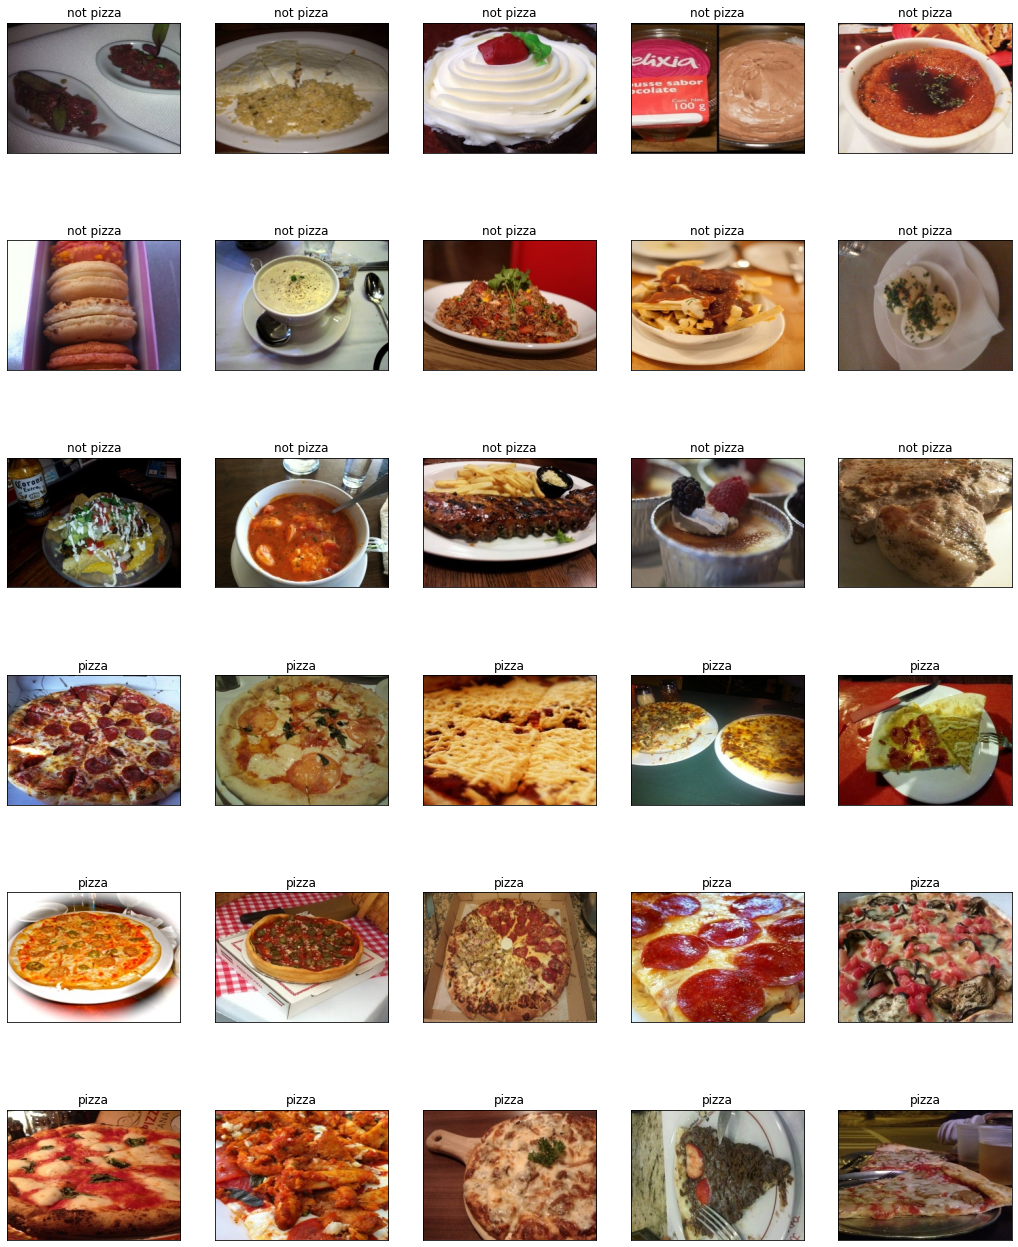

In [5]:
import matplotlib.pyplot as plt

not_pizza_imgs = X[0:15]
pizza_imgs = X[983:998]
together = np.concatenate((not_pizza_imgs, pizza_imgs))
targets_together = np.concatenate((y[0:15], y[983:998]))

fig, axes = plt.subplots(6, 5, figsize=(18, 24), subplot_kw={'xticks': (), 'yticks': ()})

plt.subplots_adjust(hspace=0)
for target, image, ax in zip(targets_together, together, axes.ravel()):
    img = np.reshape(image, (192, 256, 3))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGBA2BGR))
    ax.set_title("pizza" if target == 1 else "not pizza")

#### Implementing K Nearest Neighbors
For starters, we tried the K Nearest Neighbors approach because it was one of the simplest and allowed us to make sure we had loaded the dataset correctly. In order to get an accurate representation of how well it does, we ran it 10 times on different splits of training and test data, printing the results from each run and then the average at the end

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

print("Run # \t Training Score \t Test Score")
test_total = 0.0
training_total = 0.0

for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    knn_model = KNeighborsClassifier(n_neighbors=7)
    knn_model.fit(X_train, y_train)
    training_score = knn_model.score(X_train, y_train)
    test_score = knn_model.score(X_test, y_test)
    training_total += training_score
    test_total += test_score
    
    print(f"{x} \t {training_score} \t {test_score}")
    
print("\nAverage Scores")
print(f"Training: {training_total / 10}")
print(f"Test: {test_total / 10}")

Run # 	 Training Score 	 Test Score
0 	 0.6914758269720102 	 0.6218274111675127
1 	 0.7334605597964376 	 0.6192893401015228
2 	 0.7232824427480916 	 0.6218274111675127
3 	 0.7340966921119593 	 0.6345177664974619
4 	 0.6991094147582697 	 0.6421319796954315
5 	 0.6908396946564885 	 0.6421319796954315
6 	 0.7099236641221374 	 0.6116751269035533
7 	 0.7099236641221374 	 0.6243654822335025
8 	 0.693384223918575 	 0.6395939086294417
9 	 0.7309160305343512 	 0.6548223350253807

Average Scores
Training: 0.7116412213740458
Test: 0.6312182741116752


This model does okay, scoring an average of .71 on the training set and .63 on the test set. It potentially doesn't do super well because the dimensions of the datapoints are quite large (147456) so the curse of dimensionality makes neighbors farther apart. There's probably a way we can do this better.

#### Trying Principal Component Analysis
Hopefully using PCA we can find the most informative components and reduce the dimensionality of the data while still keeping enough information to create a good classifier. Also, reducing the number of dimensions will allow the classifier to run more quickly.

In [9]:
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pca = PCA(n_components=200, whiten=True).fit(X_train) # keeps 200 most informative components

# data mapped onto pca space
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
# Trying KNN on this transformed data
knn_model_pca = KNeighborsClassifier(n_neighbors=5)
knn_model_pca.fit(X_train_pca, y_train)
knn_model_pca.score(X_test_pca, y_test)

0.5152284263959391

The transformed data does a bit worse, getting a score slightly above 50%. With PCA, we reduce the dimensionality and lose some of the accuracy, which probably means that KNN is actually using information from all of the dimensions. 

#### Implementing Support Vector Machines

Maybe the problem is that KNN is too simple and a different model might perform better. To explore this possibility, we tried support vector machines

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.91
Accuracy on test set: 0.73


While the accuracy of this model is higher on both the training and the test set compared to KNN (0.91 vs 0.71 on training and 0.69 vs 0.63 on test when we ran it), it is also much slower to train. Maybe principal component analysis can help with speed without reducing accuracy.

#### Trying Support Vector Machines with Principal Component Analysis

In [10]:
from sklearn.svm import SVC

# all pixels will have same scale
# easier to do SVM with PCA because taking too long without PCA
svc = SVC()
svc.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_pca, y_test)))

Accuracy on training set: 0.94
Accuracy on test set: 0.64


We can see here that running a SVM with PCA gives a pretty similar accuracy to a SVM without PCA, but it is much much faster. There might be overfitting here; we can see that the accuracy on the training set is much better than the accuracy on the test set. 

#### SVM with PCA over 3 trials
Next, to see if our results were consistent or just a result of the split between training and test sets, we performed SVM with PCA over 3 trials. 

In [11]:
i = 0
max_iter = 3
total_train = 0
total_test = 0

while (i < max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    pca = PCA(n_components=200).fit(X_train) # keeps 200 most informative components
    # data mapped onto pca space
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    svc = SVC()
    svc.fit(X_train_pca, y_train)
    
    training_score = svc.score(X_train_pca, y_train)
    test_score = svc.score(X_test_pca, y_test)
    print(f"{i} \t {training_score} \t {test_score}")
    total_train += training_score 
    total_test += test_score 
    i=i+1
    
print("Average accuracy on training set: {:.2f}".format(total_train/max_iter))
print("Average accuracy on test set: {:.2f}".format(total_test/max_iter))

0 	 0.8944020356234097 	 0.7233502538071066
1 	 0.8982188295165394 	 0.7258883248730964
2 	 0.8969465648854962 	 0.6979695431472082
Average accuracy on training set: 0.90
Average accuracy on test set: 0.72


Running the test over the many trials seems to give about the same results, although when we ran it it showed test scores with an average of .73, which is slightly higher than the isolated runs we did earlier.

#### Implementing Logistic Regression

Next, we'll see if Logistic Regression does any better than SVM and KNN.

In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 1.000
Test set score: 0.591


We have a similar issue to SVM where there is overfitting, and here the overfitting is even more extreme (the training set scores 1.0 while the test set is only .61). Logistic regression does not work very well. This makes sense because it is a simpler model than SVM and therefore might struggle with the complexity of the data. It is possible that there are settings we can tweak to make it work better, but it takes such an extremely long time that it is difficult to experiment with parameters.

#### Trying Logistic Regression Principal Component Analysis

Nevertheless, we also implement logistic regression with PCA just to see if that helps.

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train_pca, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train_pca, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_pca, y_test)))

Training set score: 0.746
Test set score: 0.645


The results are a bit better for the test set, but worse for the training set. Overfitting appears to be less of a problem, but the results of the classification algorithm are still not very accurate. 

#### Implementing Neural Nets

Now, we'll see if neural nets do any better. 

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=200, alpha=.001, random_state=42, hidden_layer_sizes=([100, ]), solver = "lbfgs")
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.64


It appears a common theme here is overfitting. There is still overfitting here, but the accuracy on the test set is a bit better than logistic regression without PCA.

#### Trying Principal Component Analysis

The following code tries neural nets with the default setting and PCA. 

In [15]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_pca, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.60


We get fairly similar results to neural nets without PCA. There is still overfitting.

In the following code, we adjust some of the settings, mainly changing the alpha to see if that will decrease overfitting. 

In [16]:
mlp = MLPClassifier(max_iter=10000, alpha=1, random_state=0, hidden_layer_sizes=([10, ]))
mlp.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_pca, y_test)))

Accuracy on training set: 0.964
Accuracy on test set: 0.589


With the adjusted settings, the results are a bit better, but they still are not great. 

#### Using a CNN

We chose to try a CNN as well because we knew that they often performed well on image-related tasks. To do this, we followed the steps for preparing data and building a model that we went through as a class in the lab on Deep learning. This code is copied from that lab and then modified as necessary for our situation

In [17]:
import tensorflow as tf
from tensorflow import keras

In [18]:
# load in data - without flattening
X_cnn = []
paths = ['/not_pizza/', '/pizza/']
for path in paths:
    for filename in os.listdir("clean_data" + path):
        # load image
        img_array = cv2.imread("clean_data" + path + filename)
        X_cnn.append(img_array)
    print(f"files from {path} loaded")
    
X_cnn = np.array(X_cnn)

# Normalize pixel values to be between 0 and 1
X_cnn = X_cnn / 255.0
print(X_cnn.shape)

files from /not_pizza/ loaded
files from /pizza/ loaded
(1966, 192, 256, 3)


In [19]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[192, 256, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [20]:
from sklearn.model_selection import train_test_split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2)

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train_cnn, y_train_cnn, epochs=10)#, validation_data=(X_valid, y_valid))

Epoch 1/10
50/50 [==============================] - 245s 5s/step - loss: 1.6675 - accuracy: 0.5802
Epoch 2/10
50/50 [==============================] - 226s 5s/step - loss: 0.7040 - accuracy: 0.6425
Epoch 3/10
50/50 [==============================] - 221s 4s/step - loss: 0.5714 - accuracy: 0.7010
Epoch 4/10
50/50 [==============================] - 221s 4s/step - loss: 0.4028 - accuracy: 0.8232
Epoch 5/10
50/50 [==============================] - 225s 5s/step - loss: 0.3094 - accuracy: 0.8740
Epoch 6/10
50/50 [==============================] - 223s 4s/step - loss: 0.1893 - accuracy: 0.9421
Epoch 7/10
50/50 [==============================] - 224s 4s/step - loss: 0.0736 - accuracy: 0.9771
Epoch 8/10
50/50 [==============================] - 224s 4s/step - loss: 0.0435 - accuracy: 0.9885
Epoch 9/10
50/50 [==============================] - 224s 4s/step - loss: 0.0436 - accuracy: 0.9866
Epoch 10/10
50/50 [==============================] - 222s 4s/step - loss: 0.0535 - accuracy: 0.9822


In [22]:
score = model.evaluate(X_test_cnn, y_test_cnn)
X_new = X_test_cnn[:10]


13/13 [==============================] - 16s 1s/step - loss: 1.7716 - accuracy: 0.6396


This simple CNN does relatively well. However, the performance varied greatly based on the various training and test set splits. Because it took around 20 minutes to train, it was difficult to determine what the accuracy averaged to. With 10 epochs, it achieved a score of .99 on the training set and .92 on the test set at one point, but more commonly it would score around .90 on the training set and around .60 on the test set, which is not much of an improvement from some of the simpler models. 

#### Conclusions


In this lab, we were able to try the majority of the classification models that we learned about in class, both with and without the transformation of the data by principal component analysis. Overall, we found that support vector machines without principal component analysis performed the best out of the simpler types of models. Convolutional neural nets also performed well, but maybe not well enough to justify the higher cost of computation.